In [28]:
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score

from scipy.special import expit
from sklearn.metrics import roc_auc_score

import sys, pickle

sys.path.append('./../recipes/')
from utils import get_infer_report, get_metrics
import matplotlib.pyplot as plt
from scipy.special import softmax

def get_prediction(df):
    return df.apply(softmax, axis=1).apply(lambda x:x[1]).values


def calc_scores(df):
    r = roc_auc_score(df['sign'], df['prediction'])
    a = average_precision_score(df['sign'], df['prediction'])
    print('\t\t roc_auc_score: ', r)
    print('\t\t average_precision_score: ', a)
    return r,a
    

def add_tcrspep(df):
    df["tcrs_pep"] = df["tcra"] + ":" + df["tcrb"] + "&"  + df["peptide"] 
    df["tcr_combined"] = df["tcra"] + ":" + df["tcrb"] + "&"  + df["peptide"] 
    return df


def run_softmax(df_ours_mcpas):
    #df_ours_mcpas["ypred"] = df_ours_mcpas[["ypred0", "ypred1"]].apply(softmax, axis=1).apply(lambda x: x[1])
    df_ours_mcpas["ypred"] = df_ours_mcpas[["ypred0", "ypred1"]].apply(softmax, axis=1).ypred1 #.apply(lambda x: x[1])
    return df_ours_mcpas


def show_scores(df):
    print("roc_auc_score",roc_auc_score(y_true=df.ytrue, y_score=df.ypred))
    print("average_precision_score", average_precision_score(df.ytrue, df.ypred))    

# Load Predictions

In [2]:
!ls ../data/*parquet

../data/20221230_s_protein_prediction.parquet
../data/20230627_110913_k-1_datasettest.parquet
../data/20230627_111332_k-1_datasettest.parquet
../data/VDJdb.parquet
../data/benchmark_tpp1_mcpas_test.parquet
../data/benchmark_tpp1_mcpas_train.parquet
../data/benchmark_tpp1_vdjdb_test.parquet
../data/benchmark_tpp1_vdjdb_train.parquet
../data/dfhhb.parquet
../data/entire_data.parquet
../data/mcpas_test.parquet
../data/pdb_complex_sequences.parquet
../data/recent_data_test.parquet
../data/recent_data_test_NetTCR2.parquet
../data/recent_data_test_entire_crossatten.parquet
../data/residue_distances.parquet
../data/train_allDataTrainedModel.parquet
../data/valid_allDataTrainedModel.parquet
../data/vdjdb_no10x_test.parquet


In [3]:
ours_mcpas = pd.read_parquet("../data/20230627_111332_k-1_datasettest.parquet")
ours_vdjdb_no10x = pd.read_parquet("../data/20230627_110913_k-1_datasettest.parquet")

df_ours_mcpas = add_tcrspep(ours_mcpas)
df_ours_vdjdb_no10x = add_tcrspep(ours_vdjdb_no10x)

df_ours_mcpas = run_softmax(df_ours_mcpas)
df_ours_vdjdb_no10x = run_softmax(df_ours_vdjdb_no10x)

# Train

In [4]:
p_list = [f"./../external_data/ERGO-II/Samples/vdjdb_no10x_train_samples.pickle",
          f"./../external_data/ERGO-II/Samples/mcpas_train_samples.pickle",
        f"./../external_data/ERGO-II/Samples/vdjdb_no10x_test_samples.pickle",
          f"./../external_data/ERGO-II/Samples/mcpas_test_samples.pickle",]

df_mcpas_train = pd.DataFrame(pd.read_pickle(p_list[1])).query('tcra!="UNK"') #.query('sign==1')
df_mcpas_train['tcr_combined'] = df_mcpas_train['tcra'] + ":" + df_mcpas_train['tcrb']
df_mcpas_train = add_tcrspep(df_mcpas_train)

df_vdjdb_no10x_train = pd.DataFrame(pd.read_pickle(p_list[0])).query('tcra!="UNK"') #.query('sign==1')
df_vdjdb_no10x_train['tcr_combined'] = df_vdjdb_no10x_train['tcra'] + ":" + df_vdjdb_no10x_train['tcrb']
df_vdjdb_no10x_train = add_tcrspep(df_vdjdb_no10x_train)


##  showing no deduplication

In [5]:
print("duplication as in tcra-tcrb-pep", 
      df_ours_mcpas.tcrs_pep.isin(df_mcpas_train.tcrs_pep).value_counts()
     )

duplication as in tcra-tcrb-pep False    4729
Name: tcrs_pep, dtype: int64


# Ours MCPAS

In [6]:
print("roc_auc_score",roc_auc_score(y_true=df_ours_mcpas.ytrue, y_score=df_ours_mcpas.ypred))
print("average_precision_score", average_precision_score(df_ours_mcpas.ytrue, df_ours_mcpas.ypred))

roc_auc_score 0.9154203295458899
average_precision_score 0.6210691248216531


# Ours VDJDB

In [7]:
print("roc_auc_score",roc_auc_score(y_true=df_ours_vdjdb_no10x.ytrue, y_score=df_ours_vdjdb_no10x.ypred))
print("average_precision_score", average_precision_score(df_ours_vdjdb_no10x.ytrue, df_ours_vdjdb_no10x.ypred))

roc_auc_score 0.9445410653415244
average_precision_score 0.759975160379552


## Count overlapping

In [8]:
### overlapping Peptides
print("### overlapping Peptides")


print(df_ours_mcpas.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts())

num_ow_pep = df_ours_mcpas.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts().loc[True]
print()
print(f"There are {num_ow_pep} overlapping peptide between training and test")



### overlapping TCRs
print("\n\n")
print("### overlapping TCRs")

print("Unique tcr_combined in train", df_mcpas_train.tcr_combined.nunique())
print("Unique tcr_combined in test", df_ours_mcpas.tcr_combined.nunique())

print("is overlapping?", df_ours_mcpas.tcr_combined.drop_duplicates().isin(df_mcpas_train.tcr_combined).value_counts())



### overlapping Peptides
True     171
False     19
Name: peptide, dtype: int64

There are 171 overlapping peptide between training and test



### overlapping TCRs
Unique tcr_combined in train 18238
Unique tcr_combined in test 4197
is overlapping? False    4197
Name: tcr_combined, dtype: int64


In [9]:
df_mcpas_train.peptide.nunique(), df_ours_mcpas.peptide.nunique()

(316, 190)

In [10]:
df_ours_mcpas.peptide.isin(df_mcpas_train.peptide).value_counts()

True     4683
False      46
Name: peptide, dtype: int64

In [11]:
df_ours_mcpas['tcr_combined'] = df_ours_mcpas['tcra'] + ":" + df_ours_mcpas['tcrb']
df_mcpas_train['tcr_combined'] = df_mcpas_train['tcra'] + ":" + df_mcpas_train['tcrb']

print(df_ours_mcpas.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts())

num_ow_pep = df_ours_mcpas.peptide.drop_duplicates().isin(df_mcpas_train.peptide).value_counts().loc[True]
print(f"There are {num_ow_pep} overlapping peptide between training and test")

print("Unique tcr_combined in train", df_mcpas_train.tcr_combined.nunique())

print("Unique tcr_combined in test", df_ours_mcpas.tcr_combined.nunique())

print("is overlapping?",df_ours_mcpas.tcr_combined.drop_duplicates().isin(df_mcpas_train.tcr_combined).value_counts())


True     171
False     19
Name: peptide, dtype: int64
There are 171 overlapping peptide between training and test
Unique tcr_combined in train 3181
Unique tcr_combined in test 833
is overlapping? False    701
True     132
Name: tcr_combined, dtype: int64


In [12]:
df_valid_not_in_train = df_ours_mcpas[~df_ours_mcpas.peptide.isin(df_mcpas_train.peptide)]
df_valid_in_train = df_ours_mcpas[df_ours_mcpas.peptide.isin(df_mcpas_train.peptide)]


print('unique peptide count pep in-train', df_valid_in_train.peptide.nunique())
print('unique peptide count pep not-in-train', df_valid_not_in_train.peptide.nunique())
print('interaction count pep in-train', df_valid_in_train.shape[0])
print('interaction count pep not-in-train', df_valid_not_in_train.shape[0])

unique peptide count pep in-train 171
unique peptide count pep not-in-train 19
interaction count pep in-train 4683
interaction count pep not-in-train 46


In [13]:
print("negative_positive_ratio = ",df_ours_mcpas.ytrue.value_counts().to_dict())

print("negative_positive_ratio = ",(df_ours_mcpas.ytrue.value_counts()/len(df_ours_mcpas)).to_dict())

negative_positive_ratio =  {0: 4014, 1: 715}
negative_positive_ratio =  {0: 0.8488052442376823, 1: 0.1511947557623176}


In [14]:
df_ours_mcpas.peptide.value_counts()

LPRRSGAAGA                   569
GILGFVFTL                    474
GLCTLVAML                    288
SSYRRPVGI                    277
NLVPMVATV                    227
                            ... 
ILIVMVPFL                      1
FLRGRAYGL                      1
ILYCKRASLTELVSPRLPSHLSEYE      1
YLLPAIVHI                      1
FLWSVFMLI                      1
Name: peptide, Length: 190, dtype: int64

negative_positive_ratio = {0: 32, 1: 14}
- acc 0.6956521739130435
- balanced_acc 0.640625
- precision on 1:  0.5
- precision on 0:  0.78125
- confusion matrix tn, fp, fn, tp: 25, 7, 7, 7
- roc_auc_score 0.7321428571428572
- pr_auc_score on 1 0.5353950867282512
- pr_auc_score on 0 0.8836039775883504


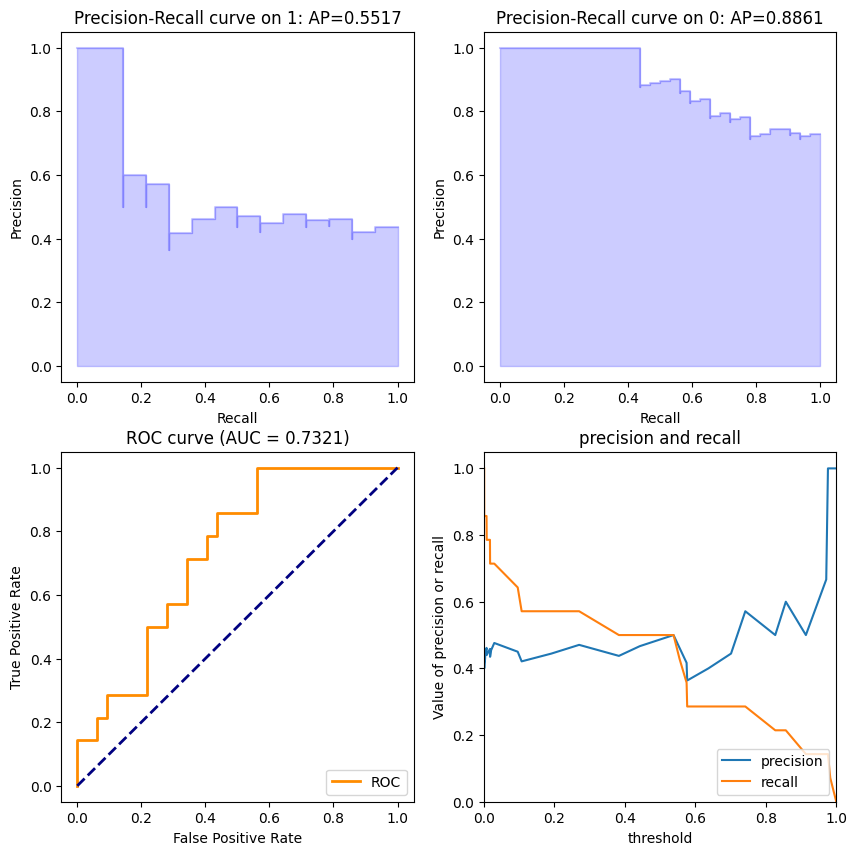

****************************************************************************************************
0    3982
1     701
Name: ytrue, dtype: int64
- acc 0.8633354687166347
- balanced_acc 0.8326585182536822
- precision on 1:  0.5291866028708134
- precision on 0:  0.9593183067619572
- confusion matrix tn, fp, fn, tp: 3490, 492, 148, 553
- roc_auc_score 0.91702837519193
- pr_auc_score on 1 0.622404983120525
- pr_auc_score on 0 0.9840439166538564


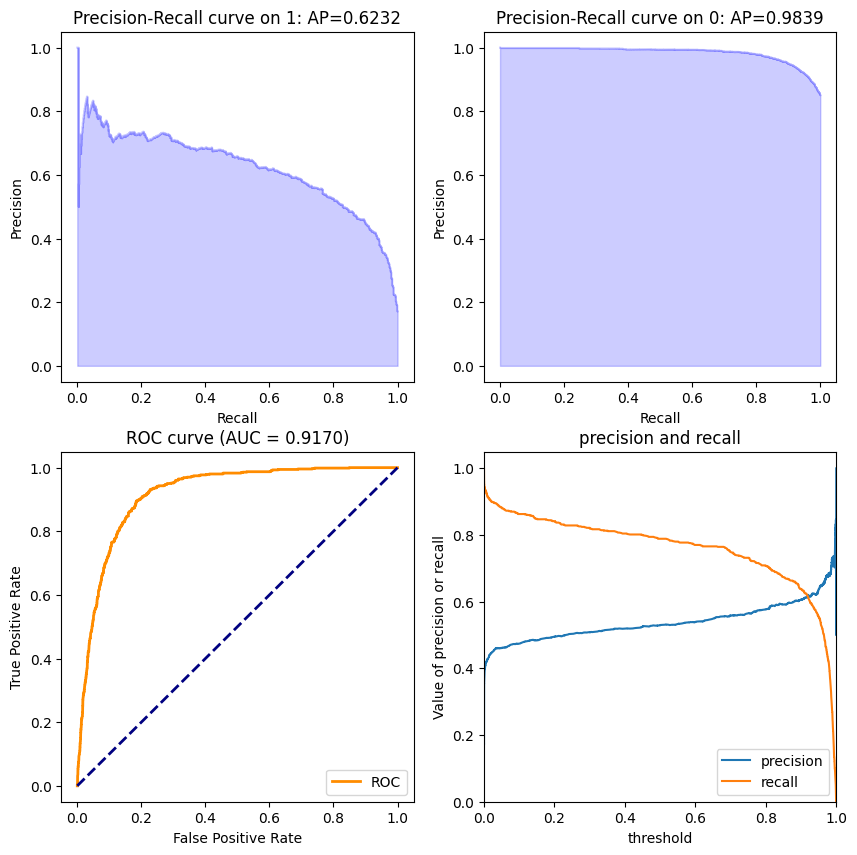

In [15]:

print("negative_positive_ratio =",df_valid_not_in_train.ytrue.value_counts().to_dict())

get_infer_report(df_valid_not_in_train.ytrue, df_valid_not_in_train.ypred)

print('*'*100)
print(df_valid_in_train.ytrue.value_counts())
get_infer_report(df_valid_in_train.ytrue, df_valid_in_train.ypred)

In [16]:
THH = 0.5
print(sum(df_valid_not_in_train.ypred>THH))
df_valid_not_in_train[(df_valid_not_in_train.ytrue==1) & (df_valid_not_in_train.ypred>THH)]

14


,ytrue,ypred0,ypred1,tcra,tcrb,peptide,tcrs_pep,tcr_combined,ypred
1211,1,-2.369350,1.352285,CAVKGEGGGADGLTF,CASNLQRAVNTEAF,PGISSQHFTYQGGVGGSWPVCSGLG,CAVKGEGGGADGLTF:CASNLQRAVNTEAF&PGISSQHFTYQGGVG...,CAVKGEGGGADGLTF:CASNLQRAVNTEAF,0.976377
1869,1,-0.885293,0.903053,CAENKDDYKLSF,CASSFSATGELFF,KLSHQPVLL,CAENKDDYKLSF:CASSFSATGELFF&KLSHQPVLL,CAENKDDYKLSF:CASSFSATGELFF,0.856724
1974,1,-0.454692,-0.151982,CAASTGGGNKLTF,CSAREGAGGMGTQYF,MTEYKLVVVGADGVGKSALTIQLI,CAASTGGGNKLTF:CSAREGAGGMGTQYF&MTEYKLVVVGADGVGK...,CAASTGGGNKLTF:CSAREGAGGMGTQYF,0.575105
2566,1,-0.079800,0.141397,CAFTSGNQFYF,CATQWTGGHEQYF,RLHDLVLPL,CAFTSGNQFYF:CATQWTGGHEQYF&RLHDLVLPL,CAFTSGNQFYF:CATQWTGGHEQYF,0.555075
3402,1,0.252395,0.404829,CAVRDQSNQFYF,CSVRVGTQYF,FSSEVLNLV,CAVRDQSNQFYF:CSVRVGTQYF&FSSEVLNLV,CAVRDQSNQFYF:CSVRVGTQYF,0.538035
3740,1,-2.304179,1.749065,CAISMDTGRRALTF,CASSEMDGSNQPQHF,FIMGISILL,CAISMDTGRRALTF:CASSEMDGSNQPQHF&FIMGISILL,CAISMDTGRRALTF:CASSEMDGSNQPQHF,0.982930
4644,1,-0.823583,0.231476,CAYRSALWGAQKLVF,CASSLAENSGNTIYF,FLWSVFMLI,CAYRSALWGAQKLVF:CASSLAENSGNTIYF&FLWSVFMLI,CAYRSALWGAQKLVF:CASSLAENSGNTIYF,0.741745


# Ours VDJDB

In [17]:
print(roc_auc_score(y_true=df_ours_vdjdb_no10x.ytrue, y_score=df_ours_vdjdb_no10x.ypred))

print(average_precision_score(y_true=df_ours_vdjdb_no10x.ytrue, y_score=df_ours_vdjdb_no10x.ypred))

0.9445410653415244
0.759975160379552


In [18]:
# !mv ../../hhyylog/20210911_043036_k0_hh.csv ../../hhyylog/20210911_043036_k0_test_hh.parquet 
# !mv ../../hhyylog/20210911_043036_k0_yy.csv ../../hhyylog/20210911_043036_k0_test_yy.parquet 

In [19]:

print("duplication as in tcra-tcrb-pep", df_ours_vdjdb_no10x.tcrs_pep.isin(df_vdjdb_no10x_train.tcrs_pep).value_counts())

df_ours_vdjdb_no10x = df_ours_vdjdb_no10x[~df_ours_vdjdb_no10x.tcrs_pep.isin(df_vdjdb_no10x_train.tcrs_pep)]

print(len(df_ours_vdjdb_no10x))
print("duplication as in tcra-tcrb-pep", df_ours_vdjdb_no10x.tcrs_pep.isin(df_vdjdb_no10x_train.tcrs_pep).value_counts())

print(
    "roc_auc_score(withtout duplication) = ", roc_auc_score(y_true=df_ours_vdjdb_no10x.ytrue, y_score=df_ours_vdjdb_no10x.ypred)
)
print(
    "average_precision_score = ", average_precision_score(y_true=df_ours_vdjdb_no10x.ytrue, y_score=df_ours_vdjdb_no10x.ypred)
)


duplication as in tcra-tcrb-pep False    4010
Name: tcrs_pep, dtype: int64
4010
duplication as in tcra-tcrb-pep False    4010
Name: tcrs_pep, dtype: int64
roc_auc_score(withtout duplication) =  0.9445410653415244
average_precision_score =  0.759975160379552


In [20]:
df_mcpas_train.peptide.apply(len).max()

25

In [21]:
print("value_counts()", df_ours_vdjdb_no10x.peptide.isin(df_vdjdb_no10x_train.peptide).value_counts())

df_valid_not_in_train = df_ours_vdjdb_no10x[~df_ours_vdjdb_no10x.peptide.isin(df_vdjdb_no10x_train.peptide)]
df_valid_in_train = df_ours_vdjdb_no10x[df_ours_vdjdb_no10x.peptide.isin(df_vdjdb_no10x_train.peptide)]


value_counts() True     3994
False      16
Name: peptide, dtype: int64


In [22]:
print('unique peptide count pep in-train', df_valid_in_train.peptide.nunique())
print('unique peptide count pep not-in-train', df_valid_not_in_train.peptide.nunique())

print('interaction count pep in-train', df_valid_in_train.shape[0])
print('interaction count pep not-in-train', df_valid_not_in_train.shape[0])


unique peptide count pep in-train 111
unique peptide count pep not-in-train 8
interaction count pep in-train 3994
interaction count pep not-in-train 16


negative_positive_ratio = {0: 8, 1: 8}
- acc 0.75
- balanced_acc 0.75
- precision on 1:  0.8333333333333334
- precision on 0:  0.7
- confusion matrix tn, fp, fn, tp: 7, 1, 3, 5
- roc_auc_score 0.828125
- pr_auc_score on 1 0.853937728937729
- pr_auc_score on 0 0.8323322510822511


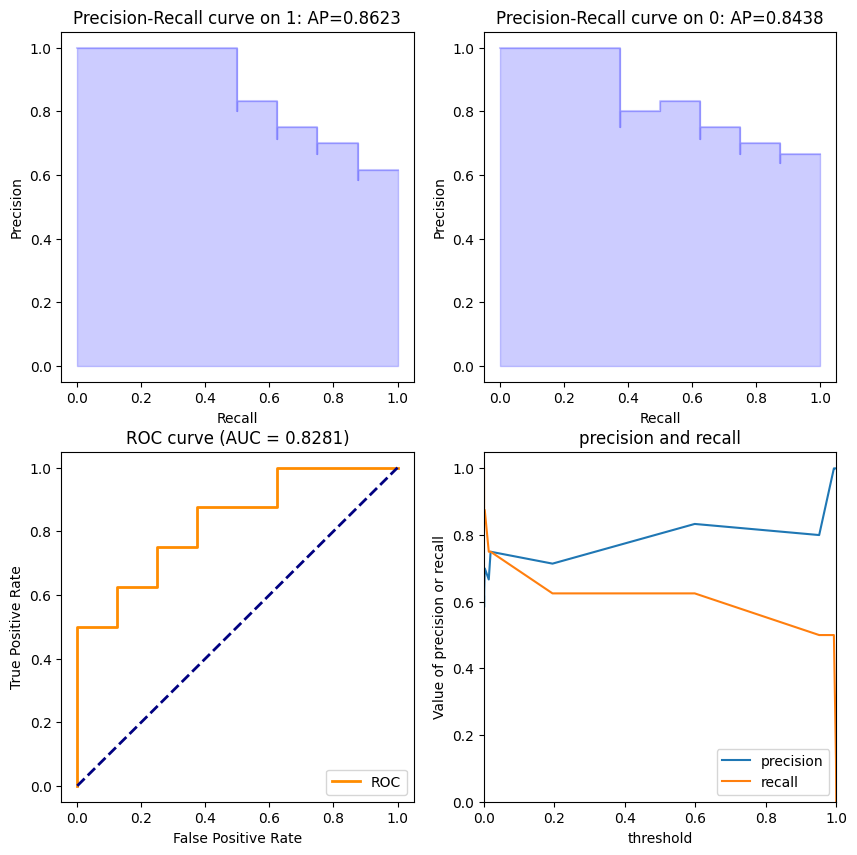

****************************************************************************************************
0    3399
1     595
Name: ytrue, dtype: int64
- acc 0.8888332498748123
- balanced_acc 0.8653632679903382
- precision on 1:  0.5899880810488677
- precision on 0:  0.9683042789223455
- confusion matrix tn, fp, fn, tp: 3055, 344, 100, 495
- roc_auc_score 0.9450708438715293
- pr_auc_score on 1 0.7593278614753591
- pr_auc_score on 0 0.9885073615051666


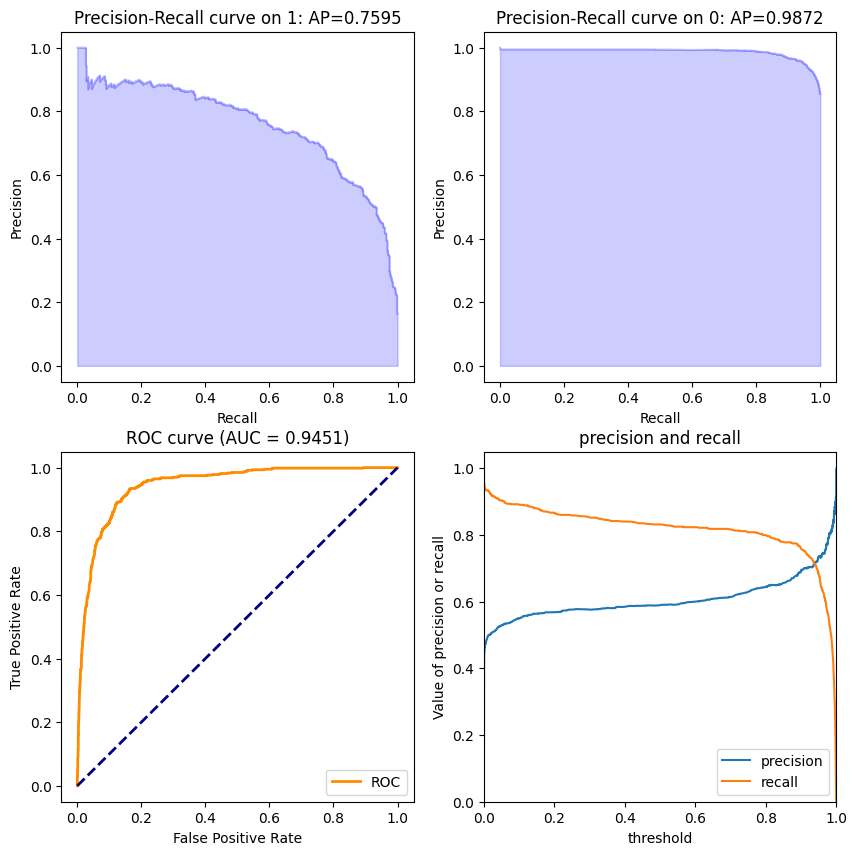

In [23]:

print("negative_positive_ratio =",df_valid_not_in_train.ytrue.value_counts().to_dict())

get_infer_report(df_valid_not_in_train.ytrue, df_valid_not_in_train.ypred)

print('*'*100)
print(df_valid_in_train.ytrue.value_counts())
get_infer_report(df_valid_in_train.ytrue, df_valid_in_train.ypred)

# Net TCR 2.0  MCPAS

In [24]:
df_mcpas_nettcr = pd.read_parquet("../data/nettcr2_mcpas.paruqet")
df_mcpas_nettcr['y_true'] = df_mcpas_nettcr.binder
df_mcpas_nettcr['y_pred'] = df_mcpas_nettcr.prediction
df_mcpas_nettcr['ytrue'] = df_mcpas_nettcr.binder
df_mcpas_nettcr['ypred'] = df_mcpas_nettcr.prediction

print(len(df_mcpas_nettcr))

print("roc_auc_score", 
      roc_auc_score(df_mcpas_nettcr.binder, df_mcpas_nettcr.prediction, ))


print("average_precision_score", 
      average_precision_score(df_mcpas_nettcr.binder, df_mcpas_nettcr.prediction, ))

4729
roc_auc_score 0.920447489730001
average_precision_score 0.5808204714703076


# Self attention

In [25]:
# ours2_mcpas = pd.read_parquet("../../hhyylog/20230703_215045_k-1_datasettest.parquet")
# ours2_vdjdb_no10x = pd.read_parquet("../../hhyylog/20230703_185102_k-1_datasettest.parquet")

# df_ours2_mcpas = add_tcrspep(ours2_mcpas)
# df_ours2_vdjdb_no10x = add_tcrspep(ours2_vdjdb_no10x)

# df_ours2_mcpas = run_softmax(df_ours2_mcpas)
# df_ours2_vdjdb_no10x = run_softmax(df_ours2_vdjdb_no10x)

# print(len(df_ours2_mcpas))
# print("roc_auc_score",roc_auc_score(y_true=df_ours2_mcpas.ytrue, y_score=df_ours2_mcpas.ypred))
# print("average_precision_score", average_precision_score(df_ours2_mcpas.ytrue, df_ours2_mcpas.ypred))

# print(len(df_ours2_vdjdb_no10x))
# print("roc_auc_score",roc_auc_score(y_true=df_ours2_vdjdb_no10x.ytrue, y_score=df_ours2_vdjdb_no10x.ypred))
# print("average_precision_score", average_precision_score(df_ours2_vdjdb_no10x.ytrue, df_ours2_vdjdb_no10x.ypred))

# Net TCR 2.0  VDJDB

In [26]:
df_vdjdb_nettcr = pd.read_parquet("../data/nettcr2_vdjdb.paruqet")
df_vdjdb_nettcr['y_true'] = df_vdjdb_nettcr.binder
df_vdjdb_nettcr['y_pred'] = df_vdjdb_nettcr.prediction
df_vdjdb_nettcr['ytrue'] = df_vdjdb_nettcr.binder
df_vdjdb_nettcr['ypred'] = df_vdjdb_nettcr.prediction


print(len(df_vdjdb_nettcr), )

print("roc_auc_score", 
      roc_auc_score(df_vdjdb_nettcr.binder, df_vdjdb_nettcr.prediction, ))

print("average_precision_score", 
      average_precision_score(df_vdjdb_nettcr.binder, df_vdjdb_nettcr.prediction, ))

4010
roc_auc_score 0.9492097773533272
average_precision_score 0.7261557306023951


In [27]:


theirs_roc_auc_score = roc_auc_score(df_mcpas_nettcr.binder, df_mcpas_nettcr.prediction,)
theirs_aps = average_precision_score(df_mcpas_nettcr.binder, df_mcpas_nettcr.prediction, )
ours_roc_auc_score = roc_auc_score(df_ours_mcpas.ytrue, df_ours_mcpas.ypred,)
ours_aps = average_precision_score(df_ours_mcpas.ytrue, df_ours_mcpas.ypred, )

compare_mcpas = pd.DataFrame([[theirs_roc_auc_score, theirs_aps],
 [ours_roc_auc_score, ours_aps],
], columns=["ROCAUC", "APS"], index=["NetTCR2.0", "OURS"])
print("MCPAS")
display(compare_mcpas)




theirs_roc_auc_score = roc_auc_score(df_vdjdb_nettcr.binder, df_vdjdb_nettcr.prediction,)
theirs_aps = average_precision_score(df_vdjdb_nettcr.binder, df_vdjdb_nettcr.prediction, )
ours_roc_auc_score = roc_auc_score(df_ours_vdjdb_no10x.ytrue, df_ours_vdjdb_no10x.ypred,)
ours_aps = average_precision_score(df_ours_vdjdb_no10x.ytrue, df_ours_vdjdb_no10x.ypred, )

compare_vdjdb_no10x = pd.DataFrame([[theirs_roc_auc_score, theirs_aps],
 [ours_roc_auc_score, ours_aps],
], columns=["ROCAUC", "APS"], index=["NetTCR2.0", "OURS"])
print("VDJDB_NO10X")
display(compare_vdjdb_no10x)

MCPAS


,ROCAUC,APS
NetTCR2.0,0.920447,0.580820
OURS,0.915420,0.621069


VDJDB_NO10X


,ROCAUC,APS
NetTCR2.0,0.949210,0.726156
OURS,0.944541,0.759975


# Per peptide

In [28]:
def show_score_by_each_peptide(df_ours_mcpas, peps):
    metrics = []
    for pep in peps:
        group = df_ours_mcpas.query(f'peptide=="{pep}"')
        
        if len(group)==0:
            continue
            
        if (group['ytrue'].mean()==0) or (group['ytrue'].mean()==1.0):
            roc_auc = None
            avg_precision = None
        else:
            roc_auc = roc_auc_score(group['ytrue'], group['ypred'])
            avg_precision = average_precision_score(group['ytrue'], group['ypred'])

        positive_rate = group['ytrue'].mean()  # assuming ytrue is binary (0 or 1)
        number_of_peptide = group.shape[0]

        metrics.append({
            'peptide': pep,
            'average_precision': avg_precision,
            'roc_auc': roc_auc,
            'positive_rate': positive_rate,
            '#_of_interactions': number_of_peptide
        })
        
    metrics_df_ours_mcpas = pd.DataFrame(metrics)
    display(metrics_df_ours_mcpas.head(3))
    return metrics_df_ours_mcpas


## McPAS

In [29]:
peps = df_ours_mcpas.peptide.value_counts().head(10).index

ours = show_score_by_each_peptide(df_ours_mcpas, peps)

ours = ours.rename(columns={'average_precision':'OurModel AP', 
                            'roc_auc':'OurModel ROCAUC', 
                    })

theirs = show_score_by_each_peptide(df_mcpas_nettcr, peps)

theirs = theirs.rename(columns={'average_precision':'NetTCR2.0 AP', 
                     'roc_auc':'NetTCR2.0 ROCAUC', 
                    }).drop(columns=['peptide','positive_rate', '#_of_interactions'])

show1 = pd.concat([ours, theirs], axis=1).dropna()

,peptide,average_precision,roc_auc,positive_rate,#_of_interactions
0,LPRRSGAAGA,NaN,NaN,0.000000,569
1,GILGFVFTL,0.480617,0.829982,0.200422,474
2,GLCTLVAML,0.552719,0.870671,0.065972,288


,peptide,average_precision,roc_auc,positive_rate,#_of_interactions
0,LPRRSGAAGA,NaN,NaN,0.000000,569
1,GILGFVFTL,0.496773,0.843633,0.200422,474
2,GLCTLVAML,0.506201,0.932107,0.065972,288


## VDJDB

In [30]:
peps = df_ours_mcpas.peptide.value_counts().head(10).index

ours = show_score_by_each_peptide(df_ours_vdjdb_no10x, peps)
ours = ours.rename(columns={'average_precision':'OurModel AP', 
                     'roc_auc':'OurModel ROCAUC', 
                    })

theirs = show_score_by_each_peptide(df_vdjdb_nettcr, peps)

theirs = theirs.rename(columns={'average_precision':'NetTCR2.0 AP', 
                     'roc_auc':'NetTCR2.0 ROCAUC', 
                    }).drop(columns=['peptide','positive_rate', '#_of_interactions'])

show2 = pd.concat([ours, theirs], axis=1).dropna()

,peptide,average_precision,roc_auc,positive_rate,#_of_interactions
0,LPRRSGAAGA,NaN,NaN,0.000000,16
1,GILGFVFTL,0.437703,0.843267,0.176923,520
2,GLCTLVAML,0.724934,0.901736,0.103960,202


,peptide,average_precision,roc_auc,positive_rate,#_of_interactions
0,LPRRSGAAGA,NaN,NaN,0.000000,16
1,GILGFVFTL,0.596851,0.886441,0.176923,520
2,GLCTLVAML,0.580583,0.946988,0.103960,202


(0.0, 1200.0)

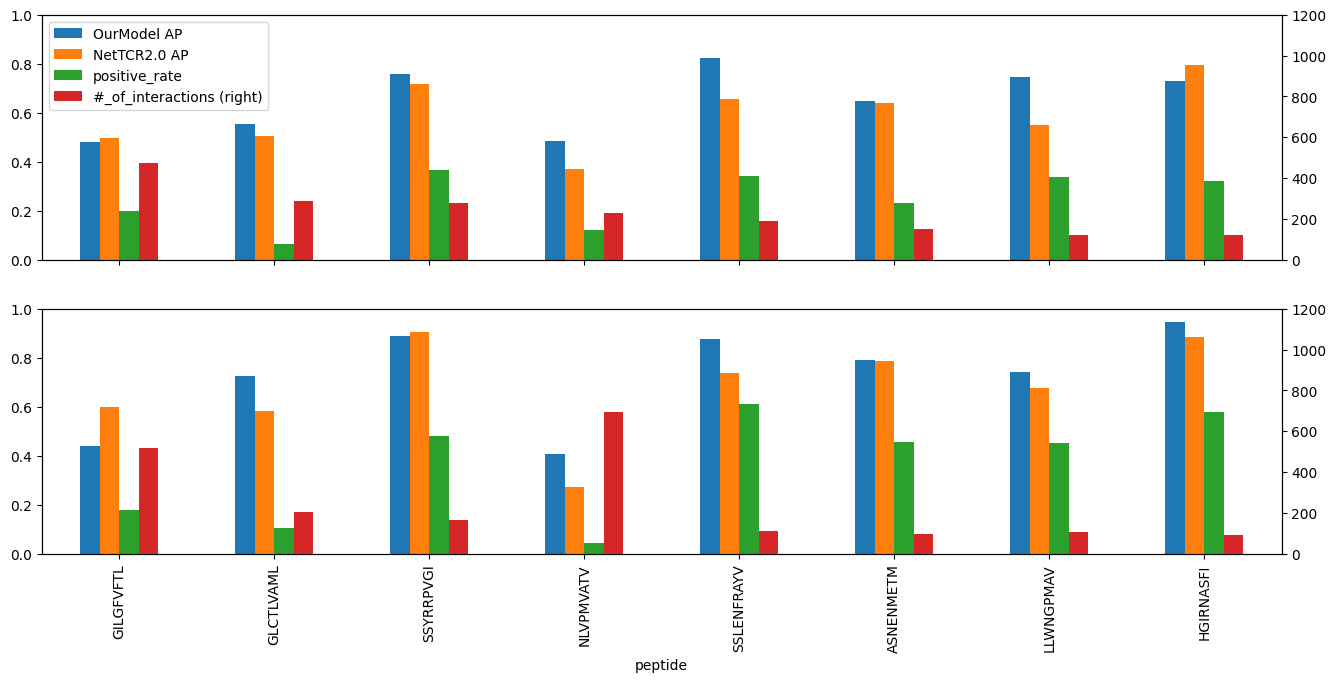

In [31]:
fig, (ax1, ax2) = plt.subplots(2,1)
show1.index = show1.peptide
show1[['OurModel AP', 'NetTCR2.0 AP', 'positive_rate', '#_of_interactions']].plot.bar(
    secondary_y=['#_of_interactions'], ax=ax1, figsize=(16,7), 
)

ax1.set_ylim(0,1.0)
ax1.right_ax.set_ylim(0,1200)
ax1.set_xticklabels(labels=list(''*len(show1)))
ax1.set_xlabel('')

# ax1.legend_(1)
# ax1.set_title('')

show2.index = show2.peptide
show2[['OurModel AP', 'NetTCR2.0 AP', 'positive_rate', '#_of_interactions']].plot.bar(
    secondary_y=['#_of_interactions'], ax=ax2, figsize=(16,7), 
    legend=False
)

ax2.set_ylim(0,1.0)
ax2.right_ax.set_ylim(0,1200)



(0.0, 1.0)

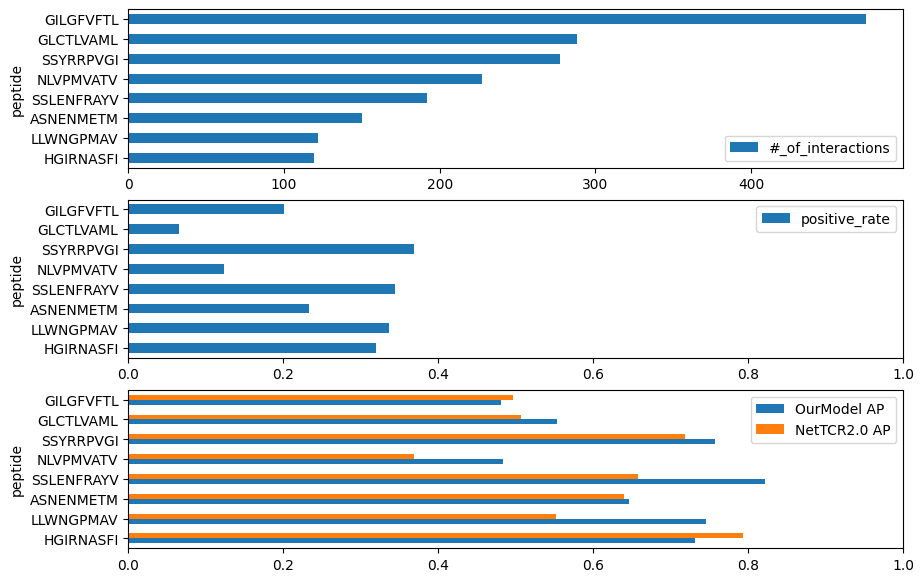

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

show1 = show1.sort_values(by=['#_of_interactions'])

show1.index = show1.peptide
show1[['#_of_interactions']].plot.barh(
    ax=ax1, figsize=(10,7), 
)

show1[['positive_rate']].plot.barh(
    ax=ax2, figsize=(10,7), 
)
ax2.set_xlim(0,1.0)

show1[['OurModel AP', 'NetTCR2.0 AP',]].plot.barh(
    ax=ax3, figsize=(10,7), 
)
ax3.set_xlim(0,1.0)

In [33]:
show1[['OurModel AP', 'NetTCR2.0 AP',]]

,OurModel AP,NetTCR2.0 AP
peptide,,
GILGFVFTL,0.480617,0.496773
GLCTLVAML,0.552719,0.506201
SSYRRPVGI,0.756788,0.717811
NLVPMVATV,0.483179,0.368951
SSLENFRAYV,0.822051,0.657639
ASNENMETM,0.646305,0.640119
LLWNGPMAV,0.745194,0.551569
HGIRNASFI,0.730893,0.793761


In [33]:
### cross
d = pd.read_parquet("/media/kyohei/forAI/tcrpred/hhyylog/20230704_221459_k-1_datasettest.parquet")
d = run_softmax(d)
show_scores(d)


FileNotFoundError: [Errno 2] No such file or directory: '/media/kyohei/forAI/tcrpred/hhyylog/20230704_221459_k-1_datasettest.parquet'

In [ ]:
### self_on_all
d = pd.read_parquet("/media/kyohei/forAI/tcrpred/hhyylog/20230704_232054_k-1_datasettest.parquet")
d = run_softmax(d)
show_scores(d)


# Recent test

In [5]:
import pandas as pd

In [6]:
ours = pd.read_parquet('../data/recent_data_test_entire_crossatten.parquet')
ours = ours.rename(columns={'pred0':'ypred0','pred1':'ypred1'})
ours['ypred'] = ours[["ypred0", "ypred1"]].apply(softmax, axis=1).ypred1
ours['ytrue'] = ours['sign']

nettcr2 = pd.read_parquet('../data/recent_data_test_NetTCR2.parquet')
nettcr2['ytrue'] = nettcr2['binder']
nettcr2['ypred'] = nettcr2['prediction']

In [7]:
show_scores(ours)

roc_auc_score 0.5362159567310181
average_precision_score 0.18549660516057023


In [8]:
show_scores(nettcr2)

roc_auc_score 0.5274640870037783
average_precision_score 0.1808650016493209


In [40]:
df0 = pd.read_parquet('../data/entire_data.parquet')

path = "../../PanPep/Data/zero_shot-table5.csv"
df_t5 = pd.read_csv(path)
df_t5['sign'] = df_t5.Label
df_t5['prediction'] = df_t5.Score

path = "../../PanPep/Data/zero_shot-table4.csv"
df_t4 = pd.read_csv(path)

In [41]:
df_t4.Peptide.isin(df_t5.Peptide).value_counts()

False    902
True     812
Name: Peptide, dtype: int64

In [50]:
df_t5.Peptide.isin(df0.peptide).value_counts()

False    798
True      14
Name: Peptide, dtype: int64

In [43]:
calc_scores(df_t5[~df_t5.Peptide.isin(df0.peptide)])

		 roc_auc_score:  0.7477842475863845
		 average_precision_score:  0.757184320575457


(0.7477842475863845, 0.757184320575457)

In [45]:
path = "../../PanPep/Data/zero_shot-table5.csv"
df_t5 = pd.read_csv(path)

In [54]:
df_t5

,Peptide,TCR,Label,Score
0,KASEKIFYV,CATSSFRMTGDNSPLHF,1,0.695660
1,KASEKIFYV,CASSQDSHSTSTDTQYF,1,0.369099
2,KASEKIFYV,CASSWEYEQYF,1,0.836944
3,KASEKIFYV,CASSALFSGANVLTF,1,0.657763
4,KASEKIFYV,CSALENGWTSGTYEQYF,0,0.189229
...,...,...,...,...
807,ALVPMVATV,CASDRVLGGNEQFF,0,0.266862
808,KSFVPELKPAF,CASTGSYGYTFGSGTRLTVT,1,0.551014
809,KSFVPELKPAF,CASSQDPGATDTQYF,0,0.335913
810,HSKRKCDEL,ASSLRGRGDQPQH,1,0.461293


In [47]:
df_t5.to_parquet("../../TCRPrediction/data/panpep_zeroshot.parquet")

In [53]:
df0['tcra'].value_counts()

CAASETSYDKVIF        647
CAVSGNYAQGLTF        622
CAIGPGNMLTF          591
CAVDLMKTSYDKVIF      583
CAGGGSQGNLIF         563
                    ... 
CAENLGYARLMF           1
CVVSDREAAGNKLTF        1
CAVEDNAGGTSYGKLTF      1
CAVEQGGKLIF            1
CLVGLSGGKLIF           1
Name: tcra, Length: 17954, dtype: int64

In [51]:
df_t5

,Peptide,TCR,Label,Score
0,KASEKIFYV,CATSSFRMTGDNSPLHF,1,0.695660
1,KASEKIFYV,CASSQDSHSTSTDTQYF,1,0.369099
2,KASEKIFYV,CASSWEYEQYF,1,0.836944
3,KASEKIFYV,CASSALFSGANVLTF,1,0.657763
4,KASEKIFYV,CSALENGWTSGTYEQYF,0,0.189229
...,...,...,...,...
807,ALVPMVATV,CASDRVLGGNEQFF,0,0.266862
808,KSFVPELKPAF,CASTGSYGYTFGSGTRLTVT,1,0.551014
809,KSFVPELKPAF,CASSQDPGATDTQYF,0,0.335913
810,HSKRKCDEL,ASSLRGRGDQPQH,1,0.461293
